In [135]:
import wandb
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import runs_store as rs

plt.rcParams['figure.dpi'] = 100

In [136]:
def load_group(group, partitions=["alpha", "hpdlf", "gpu2"]):
    result = {}
    for p in partitions:
        runs = rs.load_runs(f"../data/runs/orlopau/{p}/{group}.pickle")
        runs = rs.reduce_runs(runs).sort_values("size").reset_index(drop=True)
        result[p] = aggregate_runs(runs)

    return result

load_group("srun_nccl")["gpu2"].head()

,size,epoch,nodes,gpus,batch_size,time_sync_mean,time_sync_sum_mean,acc_test_min,acc_train_min,time_train_min,...,time_test_min,acc_test_act_min,acc_train_act_min,time_train_act_min,time_epoch_act_min,time_test_act_min,gpu_power,gpu_usage,gpu_mem,gpu_mem_usage
0,1,19,1,1,75,0.000013,0.131160,0.001722,0.001606,43.217045,...,5.400284,0.000835,0.001039,43.025843,48.439833,5.384202,37.221304,43.865347,4.821458,5.497585
1,2,19,1,2,75,0.001333,6.665688,0.001511,0.001905,32.997363,...,2.683188,0.001062,0.001289,32.789431,35.468908,2.668746,34.584364,32.757653,5.946642,3.734694
2,3,19,1,3,75,0.001489,4.963980,0.001859,0.002158,23.193875,...,2.023301,0.001065,0.001412,22.569063,24.607265,1.896064,37.447838,31.052390,5.968018,3.572072
3,4,19,1,4,75,0.001826,4.565598,0.002316,0.002444,18.365423,...,1.575293,0.001230,0.001681,18.066979,19.626053,1.478438,36.693040,30.872922,5.950000,3.495249
4,5,19,2,2,75,0.001920,3.839626,0.002023,0.002622,15.067153,...,1.323239,0.001164,0.001710,14.742050,16.084159,1.261721,37.258006,30.937861,5.941860,3.442197


In [137]:
base_acc = 0.000451

groups = {
    "75": {
        "No LR scaling": rs.load_runs(f"../data/runs/orlopau/alpha/acc_time.pickle"),
        "Linear LR scaling with warmup": rs.load_runs(f"../data/runs/orlopau/alpha/acc_time_warm.pickle"),
    },
    "1024": {
        "No LR scaling": rs.load_runs(f"../data/runs/orlopau/alpha/acc_time_big.pickle"),
        "Linear LR scaling with warmup": rs.load_runs(f"../data/runs/orlopau/alpha/acc_time_warm_big.pickle"),
    }
}

for a in groups.values():
    for group in a.values():
        group.sort(key=lambda r: r["config"]["horovod"]["size"])

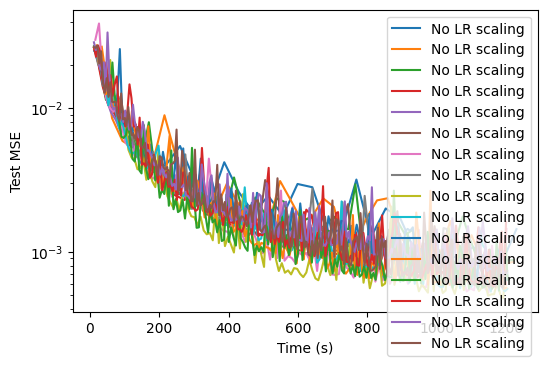

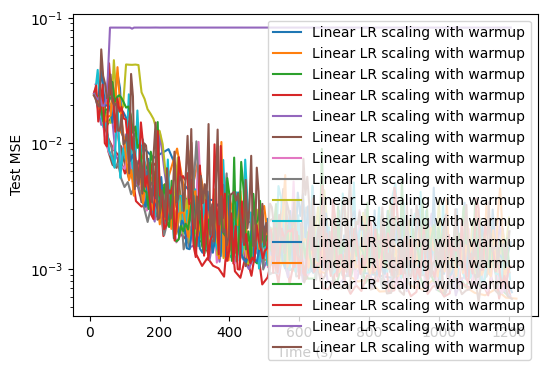

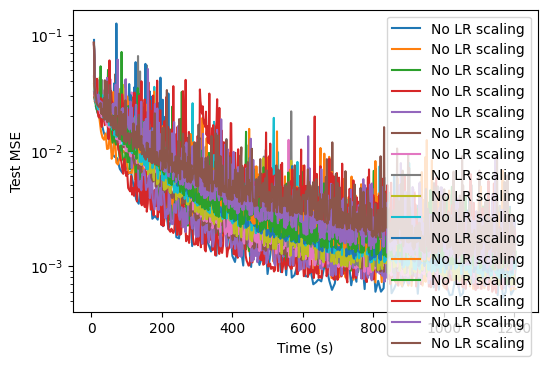

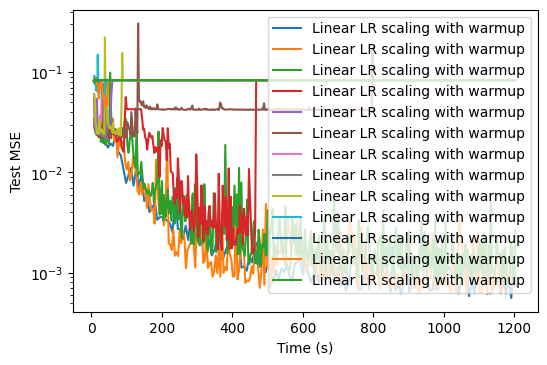

In [138]:
# plot acc vs time
for bs, group in groups.items():    
    for name, runs in group.items():
        fig, ax = plt.subplots()
        ax.set_ylabel("Test MSE")
        ax.set_xlabel("Time (s)")
        ax.set_yscale("log")

        for r in runs:
            test_accs = r["history"]["acc_test"]
            time = r["history"]["time"]
            ax.plot(time, test_accs, label=name)

        ax.legend()

In [139]:
runs = groups["1024"]["Linear LR scaling with warmup"]
runs[0].keys()

dict_keys(['id', 'summary', 'config', 'history', 'history_metrics'])

In [140]:
runs = groups["1024"]["Linear LR scaling with warmup"]
len(runs)

runs.append({
    "config": {
        "horovod": {
            "size": 10
        }},
    "history": pd.DataFrame.from_dict({
        "acc_test": [2*10**-3],
        "time": [60*1.5]
    })
})

runs.append({
    "config": {
        "horovod": {
            "size": 13
        }},
    "history": pd.DataFrame.from_dict({
        "acc_test": [2*10**-3],
        "time": [60*1.2]
    })
})

runs.append({
    "config": {
        "horovod": {
            "size": 14
        }},
    "history": pd.DataFrame.from_dict({
        "acc_test": [2*10**-3],
        "time": [60*1.8]
    })
})

groups["1024"]["Linear LR scaling with warmup"] = runs

for a in groups.values():
    for group in a.values():
        group.sort(key=lambda r: r["config"]["horovod"]["size"])

In [141]:
len(runs)

16

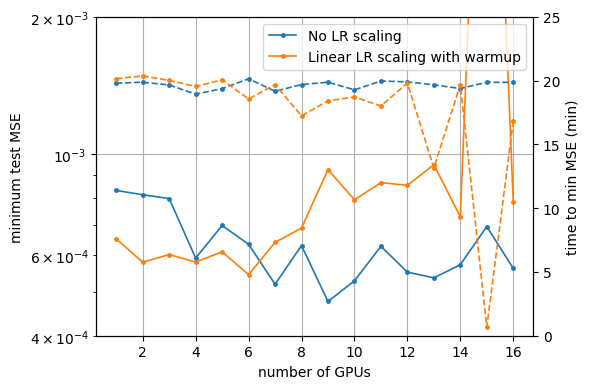

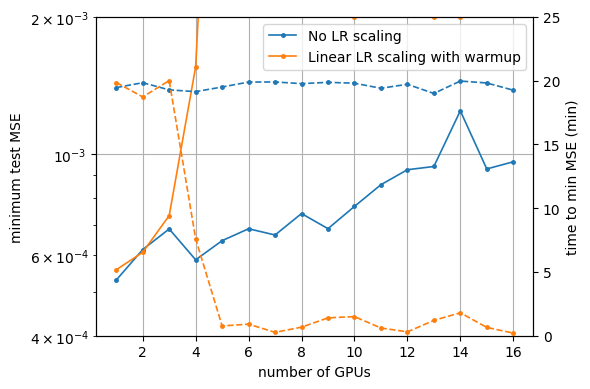

In [142]:
plot_args = {"linewidth": 1.2, "marker": "o", "markersize": 2.5}

# plot min acc vs # GPUs
for bs, group in groups.items():    
    fig, ax = plt.subplots()
    ax.set_ylabel("minimum test MSE")
    ax.set_xlabel("number of GPUs")
    ax.set_yscale("log")
    ax.set_ylim([4e-4, 2e-3])
    ax.grid()
    
    ax1 = ax.twinx()
    ax1.set_ylabel("time to min MSE (min)")
    ax1.set_ylim([0, 25])


    for name, runs in group.items():
        min_accs = [r["history"]["acc_test"].min() for r in runs]
        times = [r["history"]["time"][r["history"]["acc_test"].idxmin()] / 60 for r in runs]
        workers = [r["config"]["horovod"]["size"] for r in runs]

        ax.plot(workers, min_accs, label=name, **plot_args)
        ax1.plot(workers, times, linestyle="dashed", **plot_args)

    fig.tight_layout()
    fig.legend(bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
    fig.savefig(f"./plots/{bs}/acc_vs_workers", dpi=300)
